In [1]:
import cupy as cp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from numba.core.errors import NumbaPerformanceWarning
import numpy as np
import os
import pickle
import sys
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
os.environ['CUPY_ACCELERATORS'] = 'cub,cutensor'

sys.path.append('..')
from src import *

# Use `ipympl` for VS Code and `inline` for Jupyter/Jupyterlab
%matplotlib ipympl

## Kagome Lattice

<img src="../images/example_grid_indexing_of_lattice_sites.png" alt="Example grid indexing of lattice sites" width="900"/>

```
KagomeLattice(
    boxwidth         = 102.336,   # Box dimensions upper bound (nm)
    lattice_constant = 0.246,     # Kagome lattice constant (nm)
    energy_barrier   = 275.0,     # Energy barrier (K)
    debye_freq       = 10e10,     # Debye/attempt frequency (Hz)
    transition_type  = 't',       # Transition type (i.e. t, tr, tr2)
    intdtype         = 'int32',   # Integer data precision
    floatdtype       = 'float64'  # Float data precision
)
```

- Improved method for generating lattice sites results in a more symmetrical square box, which was not usually the case previously.
- Improved space and memory efficiency by generating site coordinates at function call rather than being explicitly stored as a variable.

## Triangular Lattice Energies

```
TriangularLatticeEnergies(
    lattice_constant = 3.936,      # Triangular lattice constant (nm)
    amplitude        = 39.8,       # Potential amplitude (meV)
    angle            = 0.0,        # Lattice orientation angle (radians)
    shift            = [0.0, 0.0]  # Lattice translation along xy (nm)
)
```

- Lattice constant for the triangular lattice potential is much larger than that of the graphene lattice. 
- So we need to determine the ideal box width that will simultaneously satisfy periodic boundary conditions for both (see notes).
- The `ideal_boxwidth()` function compares the two lattices and various box sizes up to the `target_width` and returns the box widths in the order of the smallest to the largest error. 
- For the best simulation accuracy, it is ideal to use a box width that has an error of zero, or as close to zero as possible.

In [2]:
ideal_boxwidths(
    tri_lc=3.936,      # Target triangular lattice constant
    kag_lc=0.246,      # Target kagome lattice constat
    target_width=300,  # Upper bound box width for the search
    show_topn=10        # Number of top results to display
) 

Triangular lattice test widths (first and last value): 7.872, 299.13599999999997

Kagome lattice test widths (first and last value): 7.872, 300.12

Top 10 ideal box widths (sorted by L2-norm error between lattice dimensions):
#1: 102.336nm | L2-norm error: 0.0000
#2: 204.672nm | L2-norm error: 0.0000
#3: 102.582nm | L2-norm error: 0.2460
#4: 102.090nm | L2-norm error: 0.2460
#5: 27.306nm | L2-norm error: 0.2460
#6: 54.858nm | L2-norm error: 0.2460
#7: 157.194nm | L2-norm error: 0.2460
#8: 129.642nm | L2-norm error: 0.2460
#9: 129.888nm | L2-norm error: 0.4261
#10: 55.104nm | L2-norm error: 0.4261


## Interaction Energies

```
total_impurity_energies(
    r, 
    Zval = 1.0,  # Impurity charge (dimensionless)
    epsr = 4.22  # Relative permittivity (dimensionless)
)

kappa_h(
    eps_r = 4.22,   # Relative permittivity (dimensionless)
    mu    = 0.100,  # Chemical potential (eV)
    v_f   = 1.49e6  # Fermi velocity (m/s)
)
```

$$V(r) = \dfrac{Z}{\epsilon_{r} r} \left\{ 1 - \dfrac{\pi\kappa r}{2} \big[ \text{H}_{0}(\kappa r) - \text{Y}_{0}(\kappa r) \big] \right\},\qquad \kappa = \dfrac{4|\mu|v^{2}_{H}}{\epsilon_{r}E_{H}v^{2}_{F}}$$

- For improved performance, custom CUDA kernels were replaced with **cubic spline interpolation** (on GPU). 
- This greatly improved both the performance and numerical stability of the simulation (especially at higher molecular densities).

## Temperature Function

```
temperature_function(
    duration,                 # Target duration for the simulation
    temp_initial,             # Initial simulation temperature
    temp_final    = 8.5,      # Target final temperature for the simulation
    nsamples      = 1e7,      # Number of samples for interpolation training
    method        = 'linear'  # Model for temperature decay (i.e. linear, exponential, etc.)
)
```

- Previous temperatures were incorrectly calculated as a function of KMC steps.
- Now "correctly" calculates temperatures as a function of simulation time.
- For performance, intermediate temperature values are also interpolated via SciPy's cubic spline interpolation function.
- [Kinetic Monte Carlo - slide deck (2006)](https://www.mv.helsinki.fi/home/knordlun/mc/mc8nc.pdf)
    - "Moreover, if we use Eq. 1 to derive the event probability in our simulations, we get the added advantage that we can do simulations at any temperature realistically, even if the temperature keeps changing during the modeling.”
    - *This tells us that we don't have to equilibrate each time we change temperature, we just have to carefully limit the maximum temperature change.*
- [A kinetic Monte Carlo approach to diffusion-controlled thermal desorption spectroscopy (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5468722/)
    - "As the time step depends on the temperature through the rate constants and the temperature changes with time, the time scale within the simulations must be comparable to experimental time scales to obtain meaningful results. Care must be taken if the starting temperature of the KMC simulation is too low as this would result in artificially large time steps and correspondingly large jumps in the temperature, and thus many processes that should have already occurred at lower T would be skipped... ... It is thus necessary either to carefully choose a suitable starting temperature, which is only possible if the process rates are homogeneous, or to limit the time step and only perform a KMC step if: $\Delta t(T_{1}) < t_{0} + \Delta t (T_{1} + \beta \Delta t_{0})$.”
    - *This tells us that we need to carefully limit the maximum temperature change between KMC steps to avoid the simulation potentially skipping important processes*.
    - See notes for more info.
- Early stopping has been implimented to automatically stop the simulation if either the KMC time step interval exceeds a set value `max_dt` or the simulation temperature falls outside of the desired range.

## Simulation Parameters

```
duration          = 0.001   # Duration of the simulation in seconds
frames_per_kelvin = 30      # Number of frames to sample per temperature change in Kelvin
nwarmupsteps      = 100000  # Number of warm-up steps to take before the simulation starts
progress_freq     = 250000  # Frequency of the progress output in KMC steps
max_dt            = 60      # Maximum time step interval threshold in seconds

# Energy parameters for the simulation
energy_params = {
    'lattice':'triangular',          # Lattice energy can either be 'triangular' or 'none'
    'lattice_params':{
        'lattice_constant':3.936,    # Lattice constant of the triangular lattice (nm)
        'amplitude':39.8,            # Amplitude of the triangular lattice energy (meV)
        'angle':0.0,                 # Angle of the triangular lattice (degrees)
        'shift':[0.0, 0.0]           # Shift of the triangular lattice (nm)
    },
    'interaction':'total_impurity',  # Interaction energy parameters
    'interaction_params':{
        'Zval':1.0,                  # Impurity charge value
        'epsr':4.22                  # Dielectric constant of the medium 
    }
}

# Temperature parameters for the simulation
temperature_params = {
    'temp_initial':30,  # Initial temperature of the simulation (K)
    'temp_final':8.5,   # Final temperature of the simulation (K)
    'method':'linear'   # Cooling method can be 'linear', 'exponential', or 'inv_exponential'
}

# Molecule parameters for the simulation
molecule_params = {
    'n_molecules':n_molecules,  # Number of molecules to generate
    'threshold':threshold,      # Minimum distance (in lattice constants) between initial molecule positions
}
```

## Sample Initial Configuration

With this we can choose the boxwidth with a low comparison error that is large enough for our needs. The left subplot below shows the molecules overlayed on top of the triangular lattice energy surface. The right subplot shows the Voronoi plot of each molecule with its nearest-neighboring molecules as a number of disclinations, which is one of many potentially useful indicators of phase.

Generated 7 molecule position indices in 3 attempts.
System box dimensions (nm): (7.8720, 7.6695)
Number of Kagome unit cells (columns, rows): (32, 18)
Number of total Kagome lattice sites: 3456
Packing fraction density: 0.07605452916161556


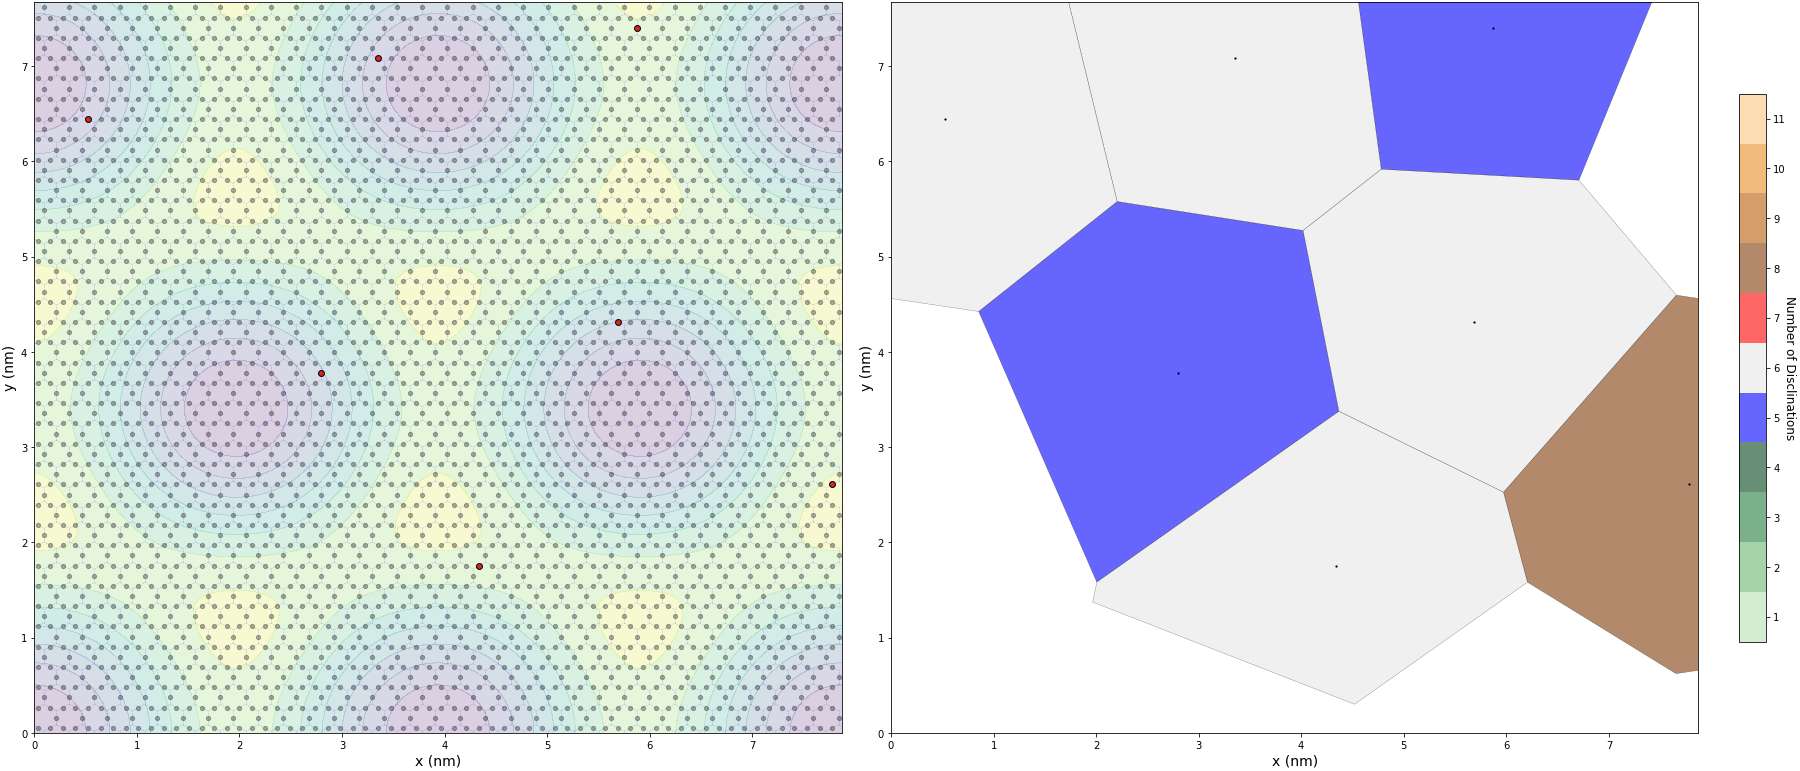

In [8]:
boxwidth    = 8 #27.306 #102.336  # Simulation box width in nanometers
n_molecules = 7      # Number of molecules to generate #400, 800, 1200, 1600, 2000
threshold   = 10       # Minimum distance (in lattice constants) between initial molecule positions #17, 12, 9, 8, 7

# Define the Kagome lattice object for the simulation (all its parameters are shown here)
# Note that the data types defined here are used for the entire simulation
kagome = KagomeLattice(
    boxwidth=boxwidth, 
    lattice_constant=0.246, 
    energy_barrier=275.0, 
    debye_freq=10e10, 
    transition_type='t', 
    intdtype='int32', 
    floatdtype='float64'
)

# The ".get_latticesites()" method to get the array of all lattice sites xy-coordinates
# An array of position indices can also be passed to get the xy-coordinates of specific lattice sites
lxy = kagome.get_latticesites(site_numbers=None)

# The ".get_sitennids()" method retrieves the array of all nearest neighbor indices for each lattice site
lnnids = kagome.get_sitennids(site_numbers=cp.arange(lxy.shape[0], dtype=kagome._idtype))

# The ".generate_randomids()" method generates random molecule positions on the lattice
if n_molecules > 0: 
    mids = kagome.generate_randomids(
        n_molecules=n_molecules, 
        sites=lxy, 
        n_attempts=1000, 
        threshold=threshold
    )

# The TriangularLatticeEnergies object is used to compute the triangular lattice energy surface
# The ".U(x,y)" method computes the energy at a given (x,y) position or array of positions
tle = TriangularLatticeEnergies(lattice_constant=3.936, amplitude=39.8, angle=0., shift=[0., 0.])

# Compute packing fraction density (for comparison, experiment e8_217.csv was: 0.037308)
xdim, ydim = kagome.boxsize
rho = (n_molecules*np.pi*0.48*0.87) / (2*xdim*ydim)
print(f"System box dimensions (nm): ({kagome.boxsize[0]:.4f}, {kagome.boxsize[1]:.4f})")
print(f"Number of Kagome unit cells (columns, rows): {kagome.n_unitcells}")
print(f"Number of total Kagome lattice sites: {kagome._n_totalsites}")
print(f"Packing fraction density: {rho}")

# The "plotter.py" module contains some functions to plot the triangular lattice energies, lattice sites, bonds, and molecules
fig, axs = plt.subplots(1, 2, figsize=(25, 11*figsize_yscale(kagome)), layout='constrained', dpi=72)
fig.canvas.resizable = False
# Plot the lattice energy surface
axs[0] = plot_latticeenergies(axs[0], tle, kagome.boxsize, nsamples=1000, cmap='viridis', alpha=0.75, zorder=1)
if boxwidth <= 10:
    # Plot the graphene lattice bonds
    axs[0] = plot_graphenebonds(axs[0], kagome, colors='b', lw=0.5, ls='--', alpha=0.25, zorder=2)
    # Plot the Kagome lattice sites
    axs[0] = plot_kagomesites(axs[0], kagome, s=18, c='k', ec='k', alpha=0.3, zorder=3)
if n_molecules > 0:
    # Plot the molecules
    axs[0] = plot_molecules(axs[0], lxy[lnnids[mids]].get(), show_nn=False, s=35, lw=1.0, mc='tab:red')
    # Plot the hexagonal order parameter
    fig, axs[1] = plot_disclinations(fig, axs[1], kagome, lxy[mids].get())
for i in range(2):
    axs[i].set(xlim=kagome.xlim, ylim=kagome.ylim)
    axs[i].set_xlabel('x (nm)', fontsize=14)
    axs[i].set_ylabel('y (nm)', fontsize=14)
plt.show()